In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib.animation as animation

import astropy.units as u
import astropy.constants as const
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, SkyOffsetFrame


from scipy.sparse.linalg import eigsh
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, minimize
from scipy.sparse.linalg import svds
from scipy.interpolate import griddata


import time as timer

import sys
sys.path.append('..')  # Add parent directory to the system path

from pint.models import get_model
from RickettTables import fitvals
from RickettEquations import *
from Curvature import *

import scintools2.scintools.ththmod as thth
from scintools2.scintools.dynspec import BasicDyn, Dynspec



import gc
from multiprocessing import Pool
from tqdm.notebook import tqdm

import warnings

warnings.filterwarnings("ignore", message="divide by zero encountered in divide")
biharmonic = False

In [2]:
from Funcs_DP import *
from Funcs_DP_Orbsim import *
from Funcs_DP_Sspec import *
from Funcs_DP_thth import *

In [3]:
dspec = np.load( "/mnt/scratch-lustre/dbaker/GB057/dspec_arar.npz")

#select only the last 3000 elements
freq_selector = [-3001,-1]

ts = (dspec['time']* u.s ).to(u.hour)
fs = dspec['freq'][freq_selector[0]:freq_selector[1]] * u.MHz
ds = dspec['ds'][freq_selector[0]:freq_selector[1]]

Text(0.5, 1.0, 'Dynamic Spectrum')

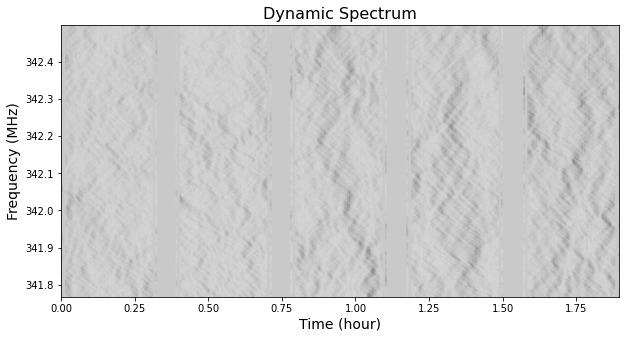

In [4]:
plt.figure(figsize=(10,5))
plt.imshow(ds,
           origin='lower',
           aspect = 'auto',
#            interpolation = None,
           vmin = np.min(ds),
           extent=ext_find(ts.to(u.hour), fs),
          cmap = 'gray_r' )
plt.xlabel("Time (hour)", fontsize = 14)
plt.ylabel('Frequency (MHz)', fontsize = 14)
plt.title("Dynamic Spectrum", fontsize = 16)

In [5]:
Om = 6.944 * (1/u.hour)
A = 6.0
c = -2.3

nu_asc = 1.4 * u.rad


#induce the mirrored versions of the dynamic spectrum
ds_orb, ts_orb = induce_mirror_motion( t = ts.to(u.hour), 
                                      nu = (ts.to(u.hour) * Om).value * u.rad - nu_asc,
                                      dyn = ds, 
                                      A = A, 
                                      phi = (ts.to(u.hour) * Om).value * u.rad, 
                                      c = c)

#induce orbital motion
tres2, dres2, res_t1, res_pos1, res_dyn1, res_tau1, res_fd1, res_CS1 = create_orbital_dynamic_spectrum( A = A, 
                                                                                                       c = c, 
                                                                                                       Om = Om,
                                                                                                       nu = (ts_orb.to(u.hour) * Om).value * u.rad - nu_asc,
                                                                                                       t = ts_orb, 
                                                                                                       f = fs, 
                                                                                                       dyn = ds_orb, 
                                                                                                       dt = 0.2)


#getting peaks and an artificial orbital phase 
phases = (tres2.to(u.hour) * Om).value * u.rad
nues = (tres2.to(u.hour) * Om).value * u.rad - nu_asc

peaksres = peaks(Ad_projection_unitless((tres2.to(u.hour)).value, 
                                        nues,
                                       phases,
                                       A,
                                       c))[0]

Text(0.5, 0, 'Time (hours)')

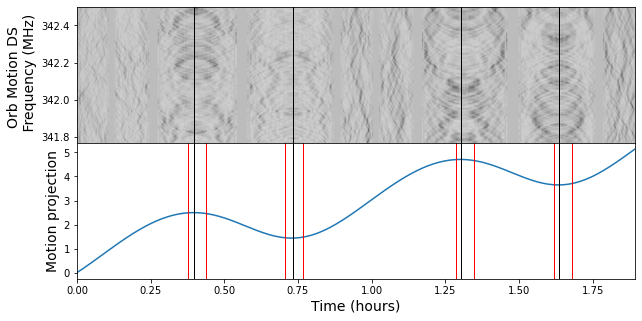

In [6]:
a_guess = tres2[peaksres].to(u.hour).value + (np.random.rand(peaksres.shape[0]) - 0.5) * (0.05)
plt.figure(figsize = (10,5))
plt.subplot(2,1,1)

plt.imshow(dres2,
           origin='lower',
           aspect = 'auto',
#            interpolation = None,
           vmin = np.min(dres2),
           extent=ext_find(tres2.to(u.hour), fs),
          cmap = 'gray_r' )

for i in range(len( peaksres) ):
    plt.axvline(x=tres2[peaksres[i]].to(u.hour).value, c='k', lw = 1.)
plt.xticks([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.ylabel("Orb Motion DS \n Frequency (MHz)", fontsize = 14)

plt.subplot(2,1,2)


plt.plot(tres2, Ad_projection_unitless((tres2.to(u.hour)).value, 
                                       nues,
                                       (tres2.to(u.hour) * Om).value * u.rad,
                                       A,
                                       c))
plt.xlim(0, np.max(tres2.value))
atol = 0.03
for i in range(len( peaksres) ):
    plt.axvline(x=tres2[peaksres[i]].to(u.hour).value, c='k', lw = 1.)
    plt.axvline(x=a_guess[i] + atol, c='r', lw = 1.)
    plt.axvline(x=a_guess[i] - atol, c='r', lw = 1.)

plt.ylabel('Motion projection', fontsize = 14)
plt.xlabel('Time (hours)', fontsize =14)

31.0


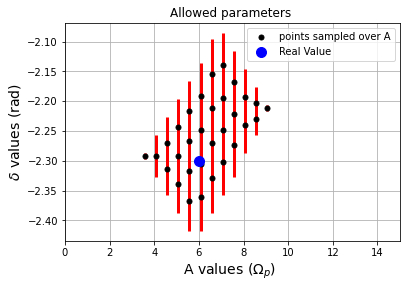

In [33]:
dyn_noise = dres2

a_guess = tres2[peaksres].to(u.hour).value + (np.random.rand(peaksres.shape[0]) - 0.5) * (0.05)
atol = 0.03

phase_storage = []
A_storage = []

#assign a limit for the range of A (the part below can be skipped if you know the range of A_multipliers)
randy1 = (np.random.rand(1) - 0.5)*2 * 2
randy2 = (np.random.rand(1) - 0.5)*2 * 2
A_multipliers =  np.linspace( 1 + randy1[0] , 12 + randy2[0], int( np.random.uniform(25, 30) ) ) 

#assign a limit on delta (in this case it was named phi)
phimin = -3
phimax = -1
Nphi = 200

#assign a tolerante for the root finder in Ad_overlap_finder
peak_tolerance = atol

#hold A fixed, and iterate to find the allowed ranges for delta
#then iterate over all A
for i in range(len(A_multipliers)):
    
    phi1 = Ad_overlap_finder(peaks = a_guess, 
                     peak_widths = peak_tolerance,
                     t = tres2.to(u.hour).value,
                     nu = nues,
                     phase = phases.value.astype(np.float64), 
                     A = A_multipliers[i], 
                     crange = np.linspace(phimin,phimax,Nphi))
    
    if phi1 != (0,0):
        phase_storage += [ phi1]
        A_storage  += [A_multipliers[i]]
        
#------------ Plot the inferred results against the true value-----------------------------------
for ai, (lower, upper) in zip(A_storage, phase_storage):
    plt.vlines(ai , lower , upper , colors='r', linewidth=3)
    
# plt.ylim(-0.7, 0)
plt.xlim(0, 15)
    
plt.grid()

plt.title("Allowed parameters " )
plt.ylabel('$\\delta$ values (rad) ', fontsize = 14)
plt.xlabel('A values $(\\Omega_p)$  ', fontsize = 14)

#split the delta value space into intervals of separation of "spacing" for all A
#this array retunrs all the possible delta values to sweep over each A
param_arr = param_space_array(Astor = A_storage, dstor = phase_storage, spacing = 0.08)

Ad_counter = 0.
for i in range(len(A_storage)):
    for j in range(len(param_arr[i])):
        if i == 0 and j ==0:
            blabel = 'points sampled over A'
        else:
            blabel = None
        plt.plot(A_storage[i], param_arr[i][j], 'ko', markersize = 5, label = blabel)
        Ad_counter += 1.
        
print(Ad_counter)

plt.plot(A,c, 'o', c = 'b', markersize= 10, label = 'Real Value')
plt.legend()

# Assign the sections to be compared-----------------  
sections_array = [(0,1), (1,2), (2,3), (3,4)]
# sections_array = [(0,1), (1,2), (2,3), (3,4), (4,5)]

A_mutipliers_array = np.array(A_storage)

In [34]:
timer2 = timer.time()
stepsizes = minimal_stepsize_calculator(t0 = tres2, 
                         nu0 = nues, 
                         freq0 = 1.,
                         phase0 = phases, 
                         A_mutipliers_array0 = A_mutipliers_array, 
                         phase_storage0 = param_arr)
print(timer.time() - timer2)

0.006165266036987305


In [35]:
timer2 = timer.time()
datas = iterator_similar_regions( sections_array0 = sections_array, 
                         dyn20 = dres2 + 1. * np.random.randn(dres2.shape[0], dres2.shape[1] ), 
                         t0 = tres2,
                         nu0 = nues,
                         freq0 = fs, 
                         phase0 = phases, 
                         A_mutipliers_array0 = A_mutipliers_array, 
                         phase_storage0 = param_arr,  
                         delt0 = 0.05)
print(timer.time() - timer2)

227.82352900505066


In [36]:
from joblib import parallel_backend, Parallel, delayed

In [54]:
timer2 = timer.time()
num_jobs = 16

freqmin = 2000
freqmax = 3000


result = Parallel(n_jobs=num_jobs)(delayed(thth_curvature_fitter)( datas[0][A_type][d_type][k][face], 
                                                                   datas[1][A_type][d_type][k][face][freqmin:freqmax], 
                                                                   fs[freqmin:freqmax],  
                                                                   300, 
                                                                   0.9 * u.s**3, 
                                                                   15.0 * u.s**3, 
                                                                   10. * u.mHz, 
                                                                   0.2,
                                                                   2,
                                                                   500. * u.us,
                                                                   0
                                                                   )
                                   for A_type in range(len(datas[0]))
                                   for d_type in range(len(datas[0][A_type]))
                                   for k in range(len(datas[0][A_type][d_type]))
                                   for face in range(len(datas[0][A_type][d_type][k]))

                                  )

print(timer.time() - timer2)

/cita/modules/python/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/cita/modules/python/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/cita/modules/python/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/cita/modules/python/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/cita/modules/python/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered 

161.04085493087769


In [43]:
result_resh = result_interpreter( ththresults = result, sample_datas = datas[0])

In [57]:
result_resh2 = result_interpreter( ththresults = result, sample_datas = datas[0])

In [45]:
def chi_calc( nnan, nnerr, margs):
    
    n = nnan[~np.isnan(nnan)]
    nerr = nnerr[~np.isnan(nnerr)]
    
    m = np.linspace(np.min(n)*margs[0],np.max(n)*margs[1], margs[2] )
    
    chis = np.zeros(len(m))
    
    for ii in range(len(m)):
        tmp = 0
        for jj in range(len(n)):
            tmp += (m[ii] - n[jj])**2 / nerr[jj]**2
#             tmp += (m[i] - n[j])**2 / m[i] 

        chis[ii] = tmp
    return np.min( chis ) / len(n)

In [46]:
chi_grid_red = []

for i in range(len(A_storage)):    
    j_list = []
    
    for j in range(len(param_arr[i])):
        
        j_list += [chi_calc( nnan = result_resh[0][i][j], nnerr = result_resh[1][i][j], margs = [0.5, 1.1, 100])]
    chi_grid_red += [j_list]

In [59]:
chi_grid_red2 = []

for i in range(len(A_storage)):    
    j_list = []
    
    for j in range(len(param_arr[i])):
        
        j_list += [chi_calc( nnan = result_resh2[0][i][j], nnerr = result_resh2[1][i][j], margs = [0.5, 1.1, 100])]
    chi_grid_red2 += [j_list]

In [335]:
chi_grid_red

[[23.127203058834645],
 [22.53376531501848],
 [26.68227683443998, 21.36444460605229],
 [21.660329916602063, 22.54354565492969, 25.47110044912819],
 [11.023090311860692, 13.697440656952512, 12.24258073778222],
 [8.492045503744963,
  10.593106470876686,
  15.346366454328264,
  18.618148920151317],
 [7.283553256165311,
  10.022696637439902,
  13.304436735235388,
  15.99460469750489,
  17.77014560171497],
 [6.136813459255246, 6.509945926760482, 9.186948654224985, 16.001884310293093],
 [9.114653476737065, 8.813793966168571, 8.568311475119383],
 [11.422661691976227, 11.562853833020466, 9.866231005776841],
 [16.394907358887128, 18.856462399573843],
 [27.681470705349298]]

In [48]:
ansstor2 = np.zeros(len(chi_grid_red))
for i in range(len(chi_grid_red)):
    ansstor2[i] = np.min( np.array(chi_grid_red[i]) )

aind = np.where( ansstor2 == np.min(ansstor2))[0][0]
dind = np.where(chi_grid_red[aind] == np.min(chi_grid_red[aind]))[0][0]

print("Best params from datas"  )
print("------------------------------")
print("A     = ", A_storage[aind])
print("delta = ", param_arr[aind][dind])
print("")

Best params from datas
------------------------------
A     =  6.074820239460498
delta =  -2.304522613065327



In [60]:
ansstor2 = np.zeros(len(chi_grid_red2))
for i in range(len(chi_grid_red)):
    ansstor2[i] = np.min( np.array(chi_grid_red2[i]) )

aind = np.where( ansstor2 == np.min(ansstor2))[0][0]
dind = np.where(chi_grid_red2[aind] == np.min(chi_grid_red2[aind]))[0][0]

print("Best params from datas"  )
print("------------------------------")
print("A     = ", A_storage[aind])
print("delta = ", param_arr[aind][dind])
print("")

Best params from datas
------------------------------
A     =  6.074820239460498
delta =  -2.3608040201005025



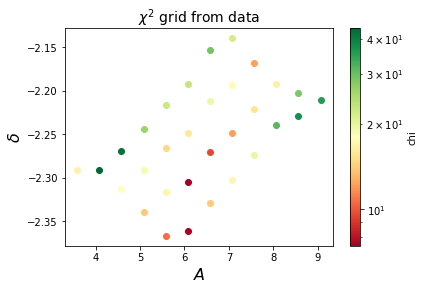

In [53]:
for i in range(len(A_storage)):
    for j in range(len(param_arr[i])):

        ctmp = (chi_grid_red[i][j] - np.min( chi_grid_red )[0] )
        ctmp /= (np.max( chi_grid_red )[0] - np.min( chi_grid_red )[0])
        
        scatter = plt.scatter(A_storage[i], param_arr[i][j], 
                    c=chi_grid_red[i][j], 
                    cmap='RdYlGn',
                    norm=LogNorm(vmin=np.min( chi_grid_red )[0], vmax=np.max( chi_grid_red )[0]))
plt.colorbar(scatter, label='chi')
plt.title("$\chi^2$ grid from data", fontsize = 14)
plt.ylabel('$\delta$', fontsize = 16)
plt.xlabel('$A$', fontsize = 16)
plt.show()

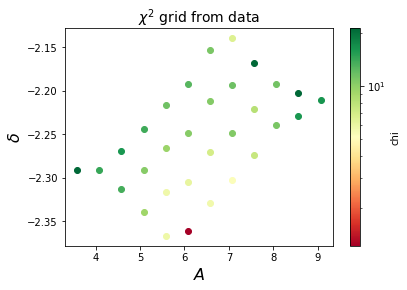

In [61]:
for i in range(len(A_storage)):
    for j in range(len(param_arr[i])):

        ctmp = (chi_grid_red2[i][j] - np.min( chi_grid_red2 )[0] )
        ctmp /= (np.max( chi_grid_red2 )[0] - np.min( chi_grid_red2 )[0])
        
        scatter = plt.scatter(A_storage[i], param_arr[i][j], 
                    c=chi_grid_red2[i][j], 
                    cmap='RdYlGn',
                    norm=LogNorm(vmin=np.min( chi_grid_red2 )[0], vmax=np.max( chi_grid_red2 )[0]))
plt.colorbar(scatter, label='chi')
plt.title("$\chi^2$ grid from data", fontsize = 14)
plt.ylabel('$\delta$', fontsize = 16)
plt.xlabel('$A$', fontsize = 16)
plt.show()

## Making them a meshgrid

In [50]:
coords = []

for i in range(len(chi_grid_red)):
    for j in range(len(chi_grid_red[i])):
        coords += [(A_storage[i], param_arr[i][j], chi_grid_red[i][j])]

# Extracting x, y, and chi values from coords
xx = np.array([coord[0] for coord in coords])
yy = np.array([coord[1] for coord in coords])
chixy = np.array([coord[2] for coord in coords])

x_grid, y_grid = np.meshgrid(np.linspace(min(xx), max(xx), 100),
                              np.linspace(min(yy), max(yy), 100))

chi_grid_int = griddata((xx, yy), chixy, (x_grid, y_grid), method='cubic')

In [62]:
coords = []

for i in range(len(chi_grid_red2)):
    for j in range(len(chi_grid_red2[i])):
        coords += [(A_storage[i], param_arr[i][j], chi_grid_red2[i][j])]

# Extracting x, y, and chi values from coords
xx = np.array([coord[0] for coord in coords])
yy = np.array([coord[1] for coord in coords])
chixy = np.array([coord[2] for coord in coords])

x_grid, y_grid = np.meshgrid(np.linspace(min(xx), max(xx), 100),
                              np.linspace(min(yy), max(yy), 100))

chi_grid_int = griddata((xx, yy), chixy, (x_grid, y_grid), method='cubic')

Text(0.5, 0, '$A$')

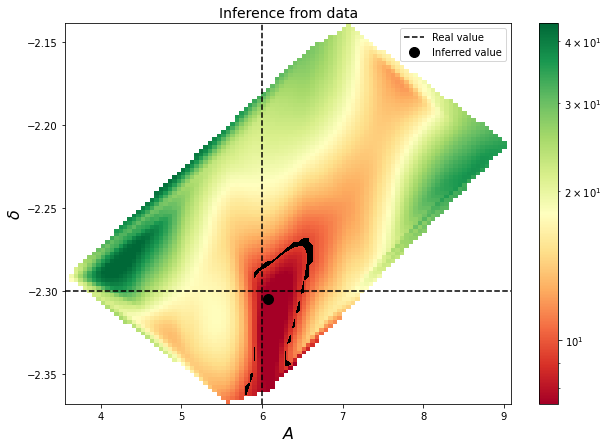

In [51]:
plt.figure(figsize = (10,7))

plt.pcolormesh(x_grid, y_grid, chi_grid_int, 
               cmap='RdYlGn', 
               norm=LogNorm(vmin=np.min( chi_grid_red )[0], vmax=np.max( chi_grid_red )[0]))
plt.colorbar()

xmins = np.min( chi_grid_red )[0]
xmaxs = np.min( chi_grid_red )[0] + 2.3
chi_masked = np.ma.masked_where((chi_grid_int > xmaxs) | (chi_grid_int < xmins), chi_grid_int)
chi_nan = chi_masked.filled(np.nan)

plt.contourf(x_grid, y_grid, chi_nan, levels=[xmaxs * 0.95, xmaxs], colors='black')

plt.axvline(x=A, color='k', linestyle='--')
plt.axhline(y=c, color='k', linestyle='--', label = 'Real value')

plt.plot(A_storage[aind], param_arr[aind][dind], 'ko', label = "Inferred value", markersize = 10)

plt.legend()
plt.title("Inference from data", fontsize = 14)
plt.ylabel('$\delta$', fontsize = 16)
plt.xlabel('$A$', fontsize = 16)

Text(0.5, 0, '$A$')

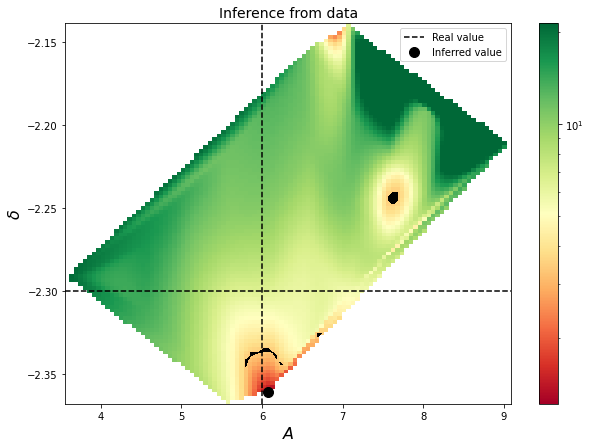

In [63]:
plt.figure(figsize = (10,7))

plt.pcolormesh(x_grid, y_grid, chi_grid_int, 
               cmap='RdYlGn', 
               norm=LogNorm(vmin=np.min( chi_grid_red2 )[0], vmax=np.max( chi_grid_red2 )[0]))
plt.colorbar()

xmins = np.min( chi_grid_red2 )[0]
xmaxs = np.min( chi_grid_red2 )[0] + 2.3
chi_masked = np.ma.masked_where((chi_grid_int > xmaxs) | (chi_grid_int < xmins), chi_grid_int)
chi_nan = chi_masked.filled(np.nan)

plt.contourf(x_grid, y_grid, chi_nan, levels=[xmaxs * 0.95, xmaxs], colors='black')

plt.axvline(x=A, color='k', linestyle='--')
plt.axhline(y=c, color='k', linestyle='--', label = 'Real value')

plt.plot(A_storage[aind], param_arr[aind][dind], 'ko', label = "Inferred value", markersize = 10)

plt.legend()
plt.title("Inference from data", fontsize = 14)
plt.ylabel('$\delta$', fontsize = 16)
plt.xlabel('$A$', fontsize = 16)

(0.0, 10.0)

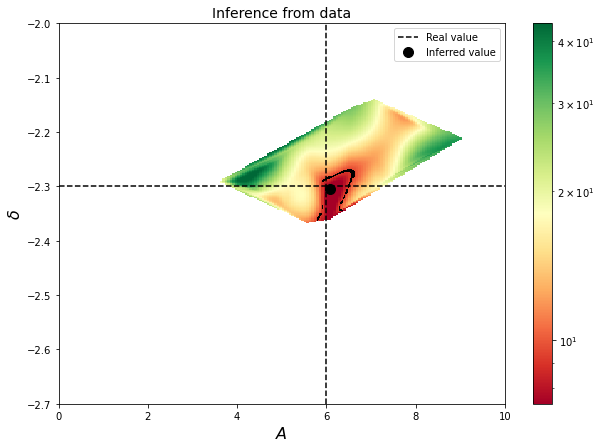

In [52]:
plt.figure(figsize = (10,7))

plt.pcolormesh(x_grid, y_grid, chi_grid_int, 
               cmap='RdYlGn', 
               norm=LogNorm(vmin=np.min( chi_grid_red )[0], vmax=np.max( chi_grid_red )[0]))
plt.colorbar()

xmins = np.min( chi_grid_red )[0]
xmaxs = np.min( chi_grid_red )[0] + 2.3
chi_masked = np.ma.masked_where((chi_grid_int > xmaxs) | (chi_grid_int < xmins), chi_grid_int)
chi_nan = chi_masked.filled(np.nan)

plt.contourf(x_grid, y_grid, chi_nan, levels=[xmaxs * 0.95, xmaxs], colors='black')

plt.axvline(x=A, color='k', linestyle='--')
plt.axhline(y=c, color='k', linestyle='--', label = 'Real value')

plt.plot(A_storage[aind], param_arr[aind][dind], 'ko', label = "Inferred value", markersize = 10)

plt.legend()
plt.title("Inference from data", fontsize = 14)
plt.ylabel('$\delta$', fontsize = 16)
plt.xlabel('$A$', fontsize = 16)
plt.ylim(-2.7, -2.0)
plt.xlim(0, 10)


(0.0, 10.0)

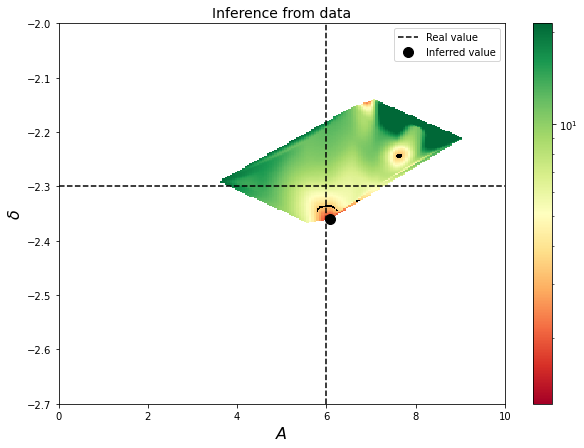

In [64]:
plt.figure(figsize = (10,7))

plt.pcolormesh(x_grid, y_grid, chi_grid_int, 
               cmap='RdYlGn', 
               norm=LogNorm(vmin=np.min( chi_grid_red2 )[0], vmax=np.max( chi_grid_red2 )[0]))
plt.colorbar()

xmins = np.min( chi_grid_red2 )[0]
xmaxs = np.min( chi_grid_red2 )[0] + 2.3
chi_masked = np.ma.masked_where((chi_grid_int > xmaxs) | (chi_grid_int < xmins), chi_grid_int)
chi_nan = chi_masked.filled(np.nan)

plt.contourf(x_grid, y_grid, chi_nan, levels=[xmaxs * 0.95, xmaxs], colors='black')

plt.axvline(x=A, color='k', linestyle='--')
plt.axhline(y=c, color='k', linestyle='--', label = 'Real value')

plt.plot(A_storage[aind], param_arr[aind][dind], 'ko', label = "Inferred value", markersize = 10)

plt.legend()
plt.title("Inference from data", fontsize = 14)
plt.ylabel('$\delta$', fontsize = 16)
plt.xlabel('$A$', fontsize = 16)
plt.ylim(-2.7, -2.0)
plt.xlim(0, 10)


/home/montalvo/.local/lib/python3.10/site-packages/scintools-0.2-py3.10.egg/scintools/ththmod.py:1242: UserWarning: eta_fit missing units. Assuming s3.
  warnings.warn(f'{name} missing units. Assuming {desired}.')
/home/montalvo/.local/lib/python3.10/site-packages/scintools-0.2-py3.10.egg/scintools/ththmod.py:1242: UserWarning: eta_sig missing units. Assuming s3.
  warnings.warn(f'{name} missing units. Assuming {desired}.')


17.94799566268921


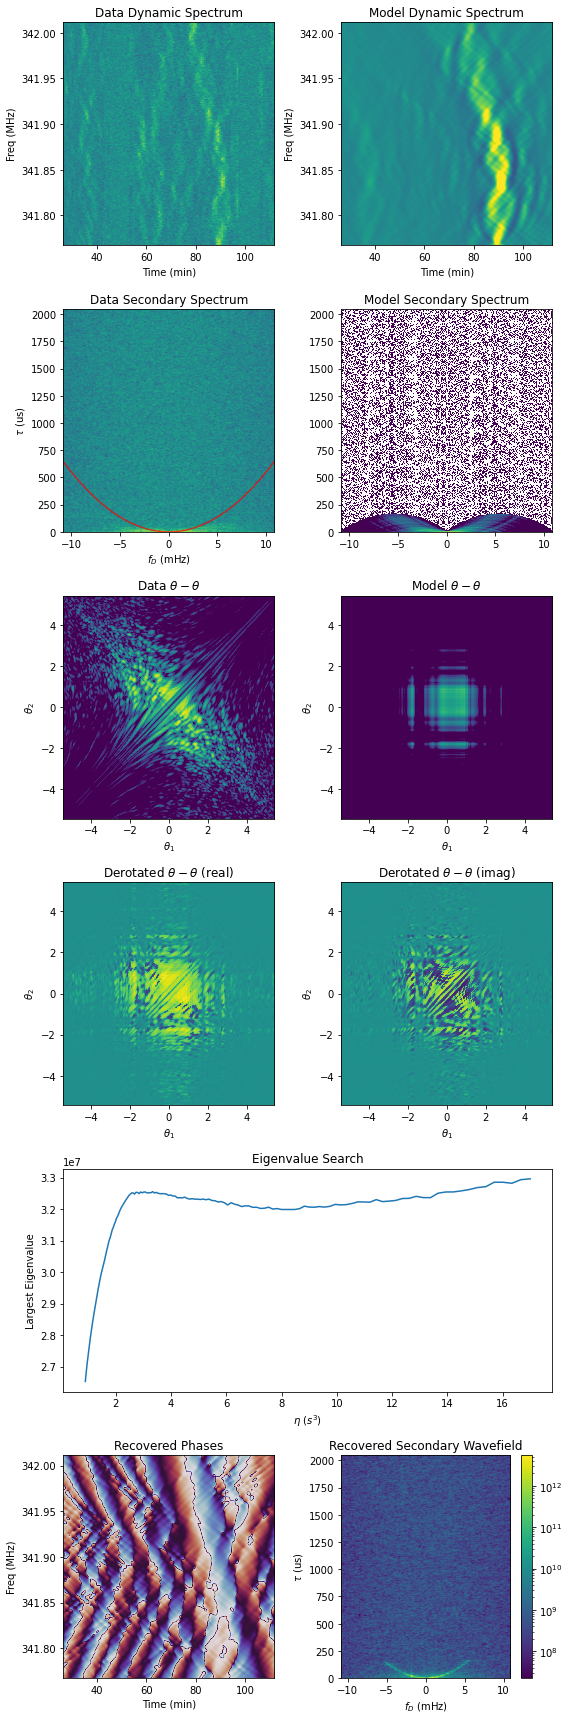

In [56]:
A_type =0
d_type = -1
k = 1

freqmin = 0
freqmax = 1000

face = 1
timer2 = timer.time()
thth_curvature_fitter3( t = datas[0][A_type][d_type][k][face], 
                       dyns = datas[1][A_type][d_type][k][face][freqmin:freqmax], 
                       freqs = fs[freqmin:freqmax], 
                       fd = datas[2][A_type][d_type][k][face], 
                       N = 300, 
                       etamin = 0.9 * u.s**3, 
                       etamax = 17 * u.s**3, 
                       elims = 10 * u.mHz, 
                       fw = 0.2, 
                       npad = 2, 
                       tau_lim = 500. * u.us, 
                       plots = 1)
print(timer.time() - timer2)

In [350]:
def thth_curvature_fitter( t, dyns, freqs, N, etamin, etamax, elims, fw, npad, tau_lim = 1000. * u.us, plots = 0):
    dspec = 0
    timet = 0
    
    if (t[1] -  t[0] < 0):
        dspec= np.flip(dyns, 1) 
        timet= np.flip( t.astype(np.float64) )
    else:
        dspec= dyns
        timet = t.astype(np.float64)
    
    #loading a dynamicspec object
    bDyne = BasicDyn(
    name="AR",
    header=["AR"],
    times=timet.value,
    freqs=freqs.value,
    dyn=dspec,
    nsub=timet.shape[0],
    nchan=freqs.shape[0],
    dt=(timet[1] - timet[0]).value,
    df=(freqs[1] - freqs[0]).value,
    )
    
    #putting our data object into scintools format 
    dyn = Dynspec()
    dyn.load_dyn_obj(dyn=bDyne, verbose = False, process=False)
    
    #prep dyn for thetatheta
    dyn.prep_thetatheta(#cwf=101,
#                     cwf = freqs.shape[0],
#                     cwt = fd.shape[0], 
                    edges_lim=elims,
                    eta_min=etamin,
                    eta_max=etamax,
                    nedge = N ,
                    verbose=False,
                    fw=fw,
                    tau_lim = tau_lim,
                    fitting_proc = 'incoherent',
                    npad = npad)
    
    #calculate curvature and error
#     ts = time.time()
    if plots == 0:
        dyn.fit_thetatheta()
        
        #in case of getting infinite retry params
        if np.isnan( ((dyn.ththeta).to(u.s**3)).value ) == True:
            
            for saver_ind in range(3):
                    #prep dyn for thetatheta
                dyn.prep_thetatheta(
                                edges_lim=elims,
                                eta_min=etamin,
                                eta_max=etamax,
                                nedge = N, #int( N * (1 + (saver_ind+1)/5) ),
                                verbose=False,
                                fw=fw * (3 - saver_ind)/4,
                                tau_lim = tau_lim,
                                fitting_proc = 'incoherent',
                                npad = npad)
                if np.isnan( ((dyn.ththeta).to(u.s**3)).value ) == True and saver_ind == 2:
                    return ((dyn.ththeta).to(u.s**3)).value, ((dyn.ththetaerr).to(u.s**3)).value
                
                dyn.fit_thetatheta()
                
                if np.isnan( ((dyn.ththeta).to(u.s**3)).value ) == False:
                    return ((dyn.ththeta).to(u.s**3)).value, ((dyn.ththetaerr).to(u.s**3)).value
        
        #in case of getting negative curvatures retry params
        elif ((dyn.ththeta).to(u.s**3)).value  < 0:
            
            for saver_ind in range(3):
                    #prep dyn for thetatheta
                dyn.prep_thetatheta(
                                edges_lim=elims,
                                eta_min=etamin,
                                eta_max=etamax,
                                nedge = N, #int( N * (1 + (saver_ind+1)/5) ),
                                verbose=False,
                                fw=fw * (3 - saver_ind)/4,
                                tau_lim = tau_lim,
                                fitting_proc = 'incoherent',
                                npad = npad)
                if ((dyn.ththeta).to(u.s**3)).value  < 0 and saver_ind == 2:
                    return ((dyn.ththeta).to(u.s**3)).value, ((dyn.ththetaerr).to(u.s**3)).value
                
                dyn.fit_thetatheta()
                
                if ((dyn.ththeta).to(u.s**3)).value  > 0:
                    return ((dyn.ththeta).to(u.s**3)).value, ((dyn.ththetaerr).to(u.s**3)).value
            
            
        else:
        
            return ((dyn.ththeta).to(u.s**3)).value, ((dyn.ththetaerr).to(u.s**3)).value
        
    else:
        dyn.thetatheta_single(cf=0, ct=0, verbose=True)

# def result_interpreter( ththresults, reg_num):
    
#     N_delta = int( len( ththresults ) / reg_num )
#     res_tmp = []
#     res_err_tmp = []
    
#     etas = np.array( ththresults )[:,0]
#     etas_err = np.array( ththresults )[:,1]
    
#     for dindex in range(N_delta):
#         res_tmp += [etas[0 + dindex * reg_num : (dindex+1) * reg_num + dindex * reg_num]]
#         res_err_tmp += [etas_err[0 + dindex * reg_num : (dindex+1) * reg_num + dindex * reg_num]]
#     return res_tmp, res_err_tmp

def chi_calc( nnan, nnerr, margs):
    
    n = nnan[~np.isnan(nnan)]
    nerr = nnerr[~np.isnan(nnerr)]
    
    m = np.linspace(np.min(n)*margs[0],np.max(n)*margs[1], margs[2] )
    
    chis = np.zeros(len(m))
    
    for ii in range(len(m)):
        tmp = 0
        for jj in range(len(n)):
            tmp += (m[ii] - n[jj])**2 / nerr[jj]**2
#             tmp += (m[i] - n[j])**2 / m[i] 

        chis[ii] = tmp
    return np.min( chis ) / len(n)

# def std_calc( nnan ):
#     n = nnan[~np.isnan(nnan)]
#     return np.std(n)

In [286]:
a123 = 0
b123 = 0

while a123 == 0:
    
    b123 += 1
    print(b123)
    
    if b123 == 3:
        a123 += 3

1
2
3
